In [2]:
import pandas as pd
import sys
import pyspark.sql
from pyspark.sql.types import StructType, StructField, DateType, StringType, DoubleType, TimestampType
from SparkDBUtils import SparkDB
import datetime
from pyspark.sql.functions import current_timestamp
import delta

sparkdb = SparkDB()
spark = sparkdb.spark

In [18]:
producto_dim_schema = StructType([
        StructField("date", DateType(), True),
        StructField("product", StringType(), True),
        StructField("product_id", StringType(), True),
        StructField("brand", StringType(), True),
        StructField("price", DoubleType(), True),
        StructField("categories", StringType(), True),
        StructField("unit_price", DoubleType(), True),
        StructField("units", StringType(), True),
        StructField("discount", DoubleType(), True),
        StructField("ts_load", TimestampType(), True)
    ])

dataset = spark.read.option("delimiter", ";").csv("../../dataset/dataset.csv",  schema= producto_dim_schema, header=True)

In [19]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=None)

In [27]:
dataset = dataset.withColumn("ts_load", current_timestamp())

In [29]:
dataset.summary().show()

+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|summary|             product|        product_id|         brand|             price|          categories|        unit_price|          units|discount|
+-------+--------------------+------------------+--------------+------------------+--------------------+------------------+---------------+--------+
|  count|              258598|            258598|        251175|            258171|              258598|            258171|         258171|       0|
|   mean|                null|184070.27116739505|          null| 3.335872270704507|                null|13.251186732823822|           null|    null|
| stddev|                null| 93759.95093658975|          null|4.6163258336936766|                null| 59.14028297290332|           null|    null|
|    min|1902 licor de gin...|               100|ABADIA DA COVA|              0.15|['Aceites. salsas...|  

In [28]:
dataset.head()

Row(date=datetime.date(2022, 11, 21), product='DIA MARI MARINERA langostino cocido 24/32 piezas caja 800 gr', product_id='8456', brand='DIA MARI MARINERA', price=7.99, categories="['Congelados', 'Pescado y marisco']", unit_price=9.99, units='€/Kg.', discount=None, ts_load=datetime.datetime(2023, 9, 15, 6, 53, 39, 969000))

In [30]:
sparkdb.write_table(dataset, "producto_dia.producto_dim", "append")

# Analisis de la migración

In [9]:
df_producto_dim = spark.table("producto_dia.producto_dim")

In [10]:
df = df_producto_dim.toPandas()
df["date"]  = pd.to_datetime(df["date"])
df.drop(columns=["discount"], inplace=True)

c:\users\carlos\proyectos\foodecommercescraper\venv\lib\site-packages\pyspark\sql\pandas\conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295609 entries, 0 to 295608
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   product_id  295609 non-null  object        
 1   product     295609 non-null  object        
 2   brand       288186 non-null  object        
 3   categories  295609 non-null  object        
 4   units       295182 non-null  object        
 5   price       295182 non-null  float64       
 6   unit_price  295182 non-null  float64       
 7   date        295609 non-null  datetime64[ns]
 8   ts_load     295609 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), object(5)
memory usage: 20.3+ MB


# Analisis de campos

**PRODUCTO**

**NULOS**

In [12]:
nulos = df[df["product"].isna()]

In [13]:
nulos["date"].unique()

array([], dtype='datetime64[ns]')

Borrado de los nulos en tabla

In [14]:
dt = delta.DeltaTable.forName(sparkdb.spark, "producto_dia.producto_dim")

In [15]:
dt.delete("product is null")

Analisis de total de productos unicos por fecha

<AxesSubplot: xlabel='date'>

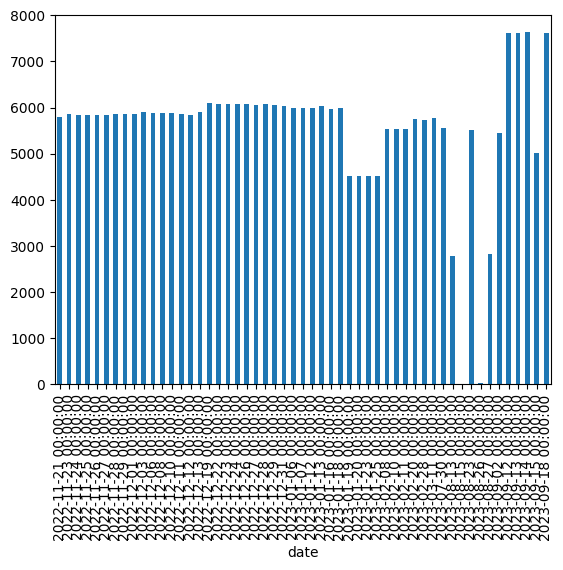

In [14]:
df.groupby("date")["product_id"].agg(pd.Series.nunique).plot(kind="bar")

**Duplicados**

In [15]:
df.groupby(["product_id","ts_load","date"])["product_id"].count().loc[lambda x: x>=2]

Series([], Name: product_id, dtype: int64)

Borrado de los duplicados

In [7]:
dt = delta.DeltaTable.forName(sparkdb.spark, "producto_dia.producto_dim")

In [8]:
dt.delete("product_id = 18013 and ts_load='2023-09-15 06:59:58.497'")